In [1]:
import os
import sys
code_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code'
code_dir_2 = '/home/ben/ben-rhodes-masters-project/proposal/code'
code_dir_3 = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code/neural_network'
code_dir_4 = '/home/ben/ben-rhodes-masters-project/proposal/code/neural_network'
code_dirs = [code_dir, code_dir_2, code_dir_3, code_dir_4]
for code_dir in code_dirs:
    if code_dir not in sys.path:
        sys.path.append(code_dir)

In [2]:
import numpy as np
import pickle

# my code
from distribution import MissingDataProductOfTruncNormsPosterior, MissingDataProductOfTruncNormNoise
from fully_observed_models import MixtureOfTwoGaussians
from latent_variable_model import MissingDataUnnormalisedTruncNorm
from nce_optimiser import NCEOptimiser
from plot import *
from utils import *
from vnce_optimiser import VemOptimiser, SgdEmStep, MonteCarloVnceLoss

from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import newton_krylov
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=1)
rc('font', size=10)
rc('legend', fontsize=10)

In [3]:
# load_path = '/home/ben/ben-rhodes-masters-project/experimental_results/trunc_norm/test/test/'
load_path = '/disk/scratch/ben-rhodes-masters-project/experimental-results/trunc_norm/test/d=2-frac=0.1/'

In [4]:
data_dist = pickle.load(open(os.path.join(load_path, 'data_dist.p'), 'rb'))

In [5]:
vnce_model = pickle.load(open(os.path.join(load_path, 'vnce_model.p'), 'rb'))

In [6]:
nce_model = pickle.load(open(os.path.join(load_path, 'nce_model.p'), 'rb'))

In [7]:
var_dist = pickle.load(open(os.path.join(load_path, 'var_dist.p'), 'rb'))

In [8]:
noise = pickle.load(open(os.path.join(load_path, 'noise.p'), 'rb'))

In [9]:
globals().update(np.load(os.path.join(load_path, 'data.npz')))
globals().update(np.load(os.path.join(load_path, 'theta0_and_theta_true.npz')))

In [10]:
# contour plot of q(z|x)p_y(x) next to cplot of model 
# do this for two cases: z is first dimension, and z is second dimension
def get_visible_and_latents(U, latent_dim=1):
    visible_dim = int(~latent_dim)
    x = np.zeros_like(U)
    z = np.zeros((1, ) + U.shape)
    
    x[:, visible_dim] = U[:, visible_dim]
    z[0, :, latent_dim] = U[:, latent_dim]
    return x, z

def joint_noise(U):
    x, z = get_visible_and_latents(U)
    return var_dist(z, x) * noise(x)

def joint_noise_rev(U):
    x, z = get_visible_and_latents(U, latent_dim=0)
    return var_dist(z, x) * noise(x)

def eval_vnce_model(U):
    x, z = get_visible_and_latents(U)
    return vnce_model(x, z)

def eval_data_dist(U):
    x, z = get_visible_and_latents(U)
    return data_dist(x, z)
    
def eval_nce_model(U):
    return nce_model(U)

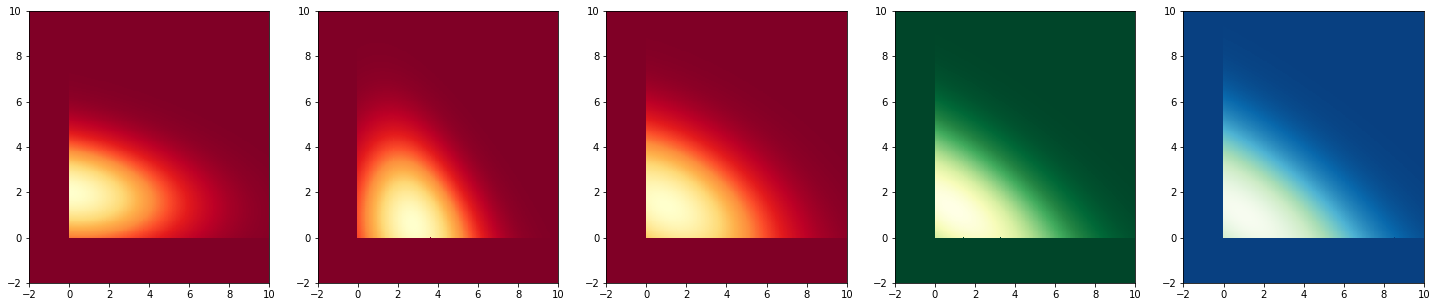

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
axs = axs.ravel()
x_low, x_high, y_low, y_high= -2, 10, -2, 10
plot_2d_density(axs[0], joint_noise, plt.cm.YlOrRd_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)
plot_2d_density(axs[1], joint_noise_rev, plt.cm.YlOrRd_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)
plot_2d_density(axs[2], eval_vnce_model, plt.cm.YlOrRd_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)
plot_2d_density(axs[3], nce_model, plt.cm.YlGn_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)
plot_2d_density(axs[4], eval_data_dist, plt.cm.GnBu_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)

In [12]:
noise.alpha

array([-0.34591672,  0.2246375 , -1.27213482, -0.86765588])

In [13]:
var_dist.nn.params

[array([[-1.21856381e-04, -2.23428880e-01],
        [-8.81679388e-02,  9.59824913e-04],
        [ 8.94201068e-04,  5.60749628e-02],
        [ 1.64546542e-02,  6.66893817e-04]]),
 array([ 2.89168281,  1.97842393, -0.71094405, -0.4590775 ])]

In [14]:
vnce_model.theta

array([-0.99531265,  0.98235523,  1.39823186, -1.14376388,  0.209814  ,
       -0.87468915])

In [15]:
nce_model.theta

array([-1.23780593,  0.87355003,  1.28419034, -1.14834365,  0.31059771,
       -1.09840241])

In [16]:
# old -  0.76872111
# noise.alpha[-2] = 0.7687211

In [17]:
np.random.uniform(np.array([1, 2, 3]), np.array([2, 3, 4]), (10,3))

array([[1.4088715 , 2.04974857, 3.14174672],
       [1.44167769, 2.94885329, 3.15226985],
       [1.90501074, 2.04448219, 3.90201907],
       [1.44689819, 2.14669519, 3.95918571],
       [1.93635487, 2.38025221, 3.63032861],
       [1.63840247, 2.35004923, 3.30220575],
       [1.48537669, 2.32936305, 3.90487352],
       [1.90589138, 2.74675113, 3.79395785],
       [1.08112696, 2.66306266, 3.90372471],
       [1.17825314, 2.26154607, 3.2734033 ]])

In [25]:
a = np.diag(np.ones(5))
b = np.diag(np.ones(4), 1)
c = np.diag(np.ones(4), -1)

In [31]:
d = a + b + c
# d[0, -1] = 1
# d[-1, 0] = 1
d

array([[1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.]])

In [32]:
np.linalg.cholesky(d)

LinAlgError: Matrix is not positive definite